In [1]:
from imp import reload

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np

In [2]:
# load a sample image
img_file_sample = './test_images/test3.jpg'
img_sample = cv2.cvtColor(cv2.imread(img_file_sample), cv2.COLOR_BGR2RGB)

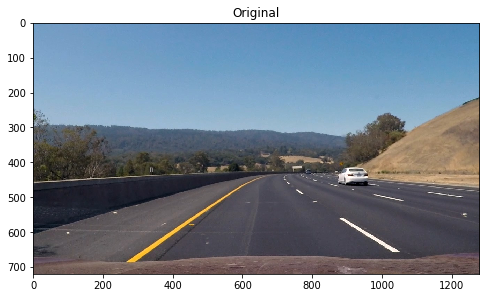

In [3]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(img_sample)
ax1.set_title('Original')
plt.show()

### Undistort

In [4]:
# get the camera matrix and the dist coeffs
from scripts import camera_cal
dist_pickle_file = './camera_cal/dist_pickle.pkl'
mtx, dist = camera_cal.camera_calibration(dist_pickle_file)

In [5]:
# undistort
img_undistorted = cv2.undistort(img_sample, mtx, dist, None, mtx)

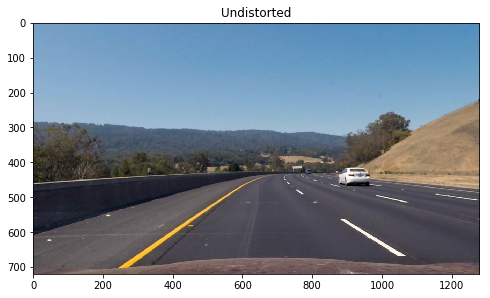

In [6]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(img_undistorted)
ax1.set_title('Undistorted')
plt.show()

### Binary image

In [7]:
from scripts import binary_image

img_binary = binary_image.process(img_undistorted, s_thresh=(170, 255), sx_thresh=(20, 100))

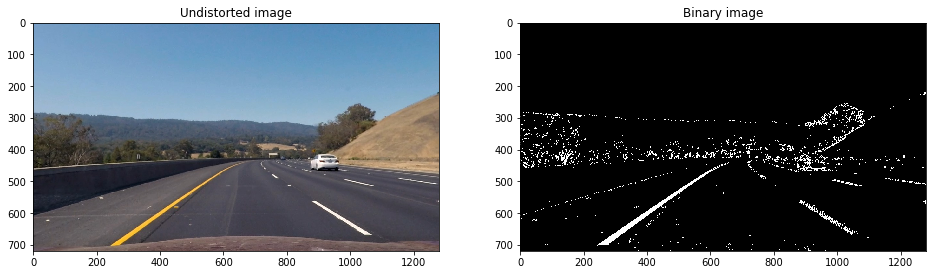

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.imshow(img_undistorted)
ax1.set_title('Undistorted image')
ax2.imshow(img_binary, cmap='gray')
ax2.set_title('Binary image')
plt.savefig('./output_images/binary_image.jpg')
plt.show()

### Perspective transform

In [9]:
from scripts import perspective_transform
reload(perspective_transform)

img_warped, src, dst = perspective_transform.process(img_binary)
img_warped_origin, src, dst = perspective_transform.process(img_undistorted)

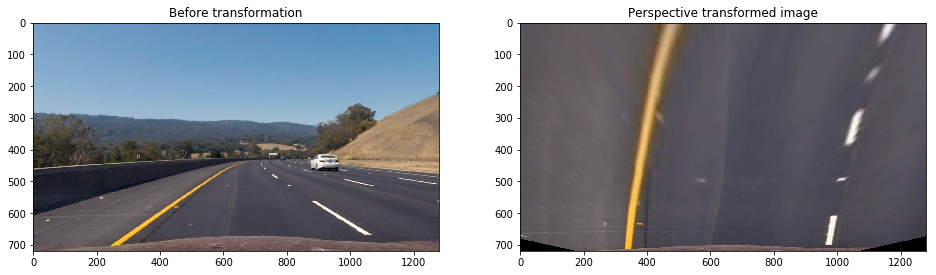

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.imshow(img_undistorted)
ax1.set_title('Before transformation')
ax2.imshow(img_warped_origin)
ax2.set_title('Perspective transformed image')
plt.show()

### Lane detection

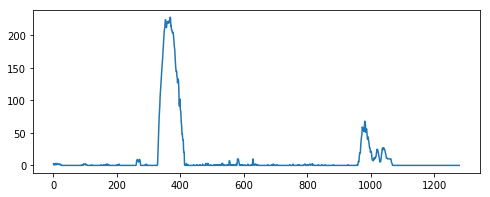

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
histogram = np.sum(img_warped[np.int(img_warped.shape[0] / 2):, :], axis=0)
ax1.plot(histogram)
plt.show()

In [12]:
img_out = np.dstack((img_warped, img_warped, img_warped)) * 255
midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print('leftx_base = ', leftx_base)
print('rightx_base = ', rightx_base)

nb_windows = 9
window_height = np.int(img_warped.shape[0] / nb_windows)
print('window_height = ', window_height)
nonzero = img_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100

minpix = 50

left_lane_inds = []
right_lane_inds = []

leftx_base =  368
rightx_base =  981
window_height =  80


In [13]:
for window in range(nb_windows):
    win_y_low = img_warped.shape[0] - (window + 1) * window_height
    win_y_high = img_warped.shape[0] - window * window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(img_out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
    cv2.rectangle(img_out, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = \
        ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
        ).nonzero()[0]
    good_right_inds = \
        ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
         (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
        ).nonzero()[0]
        
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, img_warped.shape[0] - 1, img_warped.shape[0])
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

img_out[lefty, leftx] = [255, 0, 0]
img_out[righty, rightx] = [0, 0, 255]

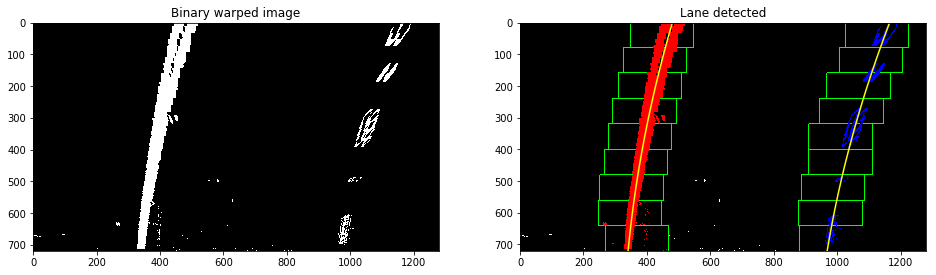

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.imshow(img_warped, cmap='gray')
ax1.set_title('Binary warped image')
ax2.imshow(img_out)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)
ax2.set_title('Lane detected')
plt.show()

In [15]:
# measuring the curvature in meter
y_eval = np.max(ploty)
ym_per_pix = 30 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

print(left_curverad, 'm', right_curverad, 'm')

1209.4788146 m 1089.94371582 m


In [16]:
img_size = img_binary.shape[1::-1]
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
# destination points
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
Minv = cv2.getPerspectiveTransform(dst, src)

In [17]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(img_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img_warped.shape[1], img_warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img_undistorted, 1, newwarp, 0.3, 0)

In [18]:
# How left from the center of the lines
loc_left = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
loc_right = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
loc_center = (loc_left + loc_right) / 2
offset = np.round((img_sample.shape[1] / 2 - loc_center) * (-1) * xm_per_pix, 2)
# Curvature
curvature = np.int(np.round((left_curverad + right_curverad) / 2))

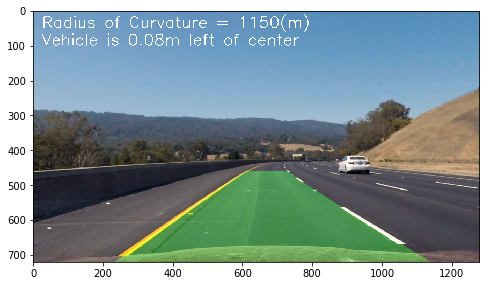

In [19]:
text_curvature = 'Radius of Curvature = {}(m)'.format(curvature)
text_location = 'Vehicle is {}m left of center'.format(offset)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, text_curvature, (25, 50), font, 1.5, (255, 255, 255), 2)
cv2.putText(result, text_location, (25, 100), font, 1.5, (255, 255, 255), 2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.imshow(result)
plt.show()

### pipeline test

In [3]:
from scripts import pipeline
from scripts import line

l = line.Line()
p = pipeline.Pipeline(l)

img = cv2.imread('./test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_pipelined = p.process(img)

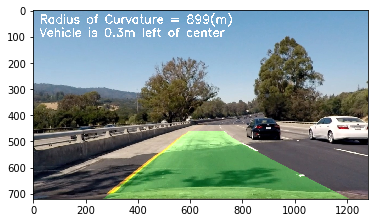

In [4]:
plt.imshow(img_pipelined)
plt.show()

### output video

In [5]:
from imp import reload

from IPython.display import HTML
from moviepy.editor import VideoFileClip

from scripts import pipeline
from scripts import line

l = line.Line()
p = pipeline.Pipeline(l)

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(p.process)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:26<00:00,  6.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 17s, sys: 45.9 s, total: 4min 3s
Wall time: 3min 27s
